# 2019/11/21
## With assigned TNT & Census Tract

In [1]:
import os
import pandas as pd
import numpy as np
import json
from datetime import datetime
from IPython.display import display, HTML, IFrame
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopandas import GeoDataFrame
import geopy
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import fiona
from shapely.geometry import Point, Polygon
import folium
from scipy import stats
import researchpy as rp

%matplotlib inline

# The files used below has already been cleaned and formatted and are not the original raw data from Syracuse
The code for address cleaning is available in the collapsed cell

In [ ]:
dfc = pd.read_csv(r'Data/original/Cityline_Calls_for_Service_New.csv')

dfc=dfc[(dfc['complaint_type_name']=='Blue Bin Skip') |
      (dfc['complaint_type_name']=='Trash Skip') |
      (dfc['complaint_type_name']=='Illegal Trash Set Out')]

dfc = dfc[(dfc['address'].str.contains(' [Tt][Oo] ')==False) & 
                              (dfc['address'].str.contains(' [Aa][Tt] ')==False) &
                              (dfc['address'].str.contains('&')==False)]

dfc.loc[dfc['address'].str.contains(' Rear$'),'address']=dfc['address'].str.replace(' Rear$','')

dfc.loc[dfc['address'].str.contains(' N$'),'address'] = 'North '+dfc['address'].str[:-2]
dfc.loc[dfc['address'].str.contains(' S$'),'address'] = 'South '+dfc['address'].str[:-2]
dfc.loc[dfc['address'].str.contains(' E$'),'address'] = 'East '+dfc['address'].str[:-2]
dfc.loc[dfc['address'].str.contains(' W$'),'address'] = 'West '+dfc['address'].str[:-2]

dfc['address']=dfc['address'].str.replace(' Ave$',' Avenue').str.replace(' Blvd$',' Boulevard').str.replace(' Cir$',' Circle'
                                        ).str.replace(' Ct$',' Court').str.replace(' Dr$',' Drive').str.replace(' Ext$',' Extension',
                                                                     ).str.replace(' Ln$',' Lane'
                                                                     ).str.replace(' Pk$',' Park'
                                                                     ).str.replace(' Pkwy$',' Parkway'
                                                                     ).str.replace(' Pl$',' Place'
                                                                     ).str.replace(' Rd$',' Road'
                                                                     ).str.replace(' Sq$',' Square'
                                                                     ).str.replace(' St$',' Street'
                                                                     ).str.replace(' Terr$',' Terrace'
                                                                     ).str.replace(' Tnpk$',' Turnpike'
                                                                     ).str.replace(' Luthr ',' Luther ')

dfc['street_address']=dfc['number']+' '+dfc['address'].str.upper()

dfp = pd.read_csv(r'Data/original/Parcel_Data_April_2018.csv')

dfp.loc[dfp['FullName'].str.contains('&'), 'FullName'] = dfp['FullName'].str.extract('(.*)&')[0]
dfp.loc[dfp['FullName'].str.contains(' & '), 'FullName'] = dfp['FullName'].str.extract('(.*) & ')[0]
dfp.loc[dfp['FullName'].str.contains(' TO '), 'FullName'] = dfp['FullName'].str.extract('(.*) TO ')[0]
dfp.loc[dfp['FullName'].str.contains(' AT '), 'FullName'] = dfp['FullName'].str.extract('(.*) AT ')[0]
dfp.loc[dfp['FullName'].str.contains(' $'), 'FullName'] = dfp['FullName'].str.extract('(.*) $')[0]
dfp.loc[dfp['FullName'].str.contains(' REAR'), 'FullName'] = dfp['FullName'].str.extract('(.*) REAR')[0]
dfp.loc[dfp['FullName'].str.contains(' R '), 'FullName'] = dfp['FullName'].str.extract('(.*) R')[0]
dfp.loc[dfp['FullName'].str.contains(' $'), 'FullName'] = dfp['FullName'].str.extract('(.*) $')[0]
dfp.loc[dfp['FullName'].str.contains(' SIDE$'), 'FullName'] = dfp['FullName'].str.extract('(.*) SIDE$')[0]
dfp.loc[dfp['FullName'].str.contains('114 SABINE'), 'FullName'] = dfp['FullName'] + ' ST'
dfp.loc[dfp['FullName'].str.contains('194 CHAFFEE'), 'FullName'] = dfp['FullName'] + ' ST'

dfp.loc[dfp['FullName'].str.contains(' E$'),'FullName']=dfp['FullName'].str.extract('([^A-Z]*) ')[0]+' EAST '+dfp['FullName'].str.extract('[^A-Z]* (.*) [A-Z]$')[0]
dfp.loc[dfp['FullName'].str.contains(' W$'),'FullName']=dfp['FullName'].str.extract('([^A-Z]*) ')[0]+' WEST '+dfp['FullName'].str.extract('[^A-Z]* (.*) [A-Z]$')[0]
dfp.loc[dfp['FullName'].str.contains(' N$'),'FullName']=dfp['FullName'].str.extract('([^A-Z]*) ')[0]+' NORTH '+dfp['FullName'].str.extract('[^A-Z]* (.*) [A-Z]$')[0]
dfp.loc[dfp['FullName'].str.contains(' S$'),'FullName']=dfp['FullName'].str.extract('([^A-Z]*) ')[0]+' SOUTH '+dfp['FullName'].str.extract('[^A-Z]* (.*) [A-Z]$')[0]

dfp['FullName']=dfp['FullName'].str.replace(' AVE*$',' AVENUE').str.replace(' ALY$',' ALLEY'
                              ).str.replace(' BLVD$',' BOULEVARD').str.replace(' BRG$',' BRIDGE').str.replace(' CIR$',' CIRCLE'
                              ).str.replace(' CT$',' COURT').str.replace(' DR$',' DRIVE' ).str.replace(' EXT$',' EXTENSION',
                              ).str.replace(' GRN$',' GREEN').str.replace(' L[AN]$',' LANE').str.replace(' PK$',' PARK'
                              ).str.replace(' PKWY$',' PARKWAY').str.replace(' PL$',' PLACE').str.replace(' RD$',' ROAD'
                              ).str.replace(' SQ$',' SQUARE').str.replace(' ST$',' STREET').str.replace(' TER+$',' TERRACE'
                              ).str.replace(' TNPK$',' TURNPIKE')

dfc.to_csv('data/working/dfc.csv')
dfp.to_csv('data/working/dfp.csv')

In [2]:
dfp = pd.read_csv('data/working/dfp.csv')
dfc = pd.read_csv('data/working/dfc.csv')
dfd = pd.read_csv(r'data/original/1216_ACS.csv', dtype={'FIPS': 'str'})
tt = pd.read_csv('data/working/tnt_tract.csv',dtype={'FIPS': 'str'})

In [3]:
dfp = dfp.drop(columns='TNT_NAME')

In [4]:
dfm = pd.merge(dfc,
               dfp.drop_duplicates('FullName'),
               left_on = 'street_address',
               right_on = 'FullName',
               how = 'left',
               validate = 'm:1',
               indicator = True)

dfm['CensusTrac']=dfm['CensusTrac'].str.replace('Null','0').str.replace(' ','0').astype(float)*100
dfm['CensusTrac']=dfm['CensusTrac'].fillna(0).astype(int).astype(str).str.zfill(6)
dfm['FIPS'] = '36067' + dfm['CensusTrac']
dfm['_merge'].value_counts()

both          7069
left_only       41
right_only       0
Name: _merge, dtype: int64

In [5]:
dfm2 = pd.merge(dfm.drop(columns='_merge'),
                tt,
                on = 'FIPS',
                how = 'left',
                validate = 'm:1',
                indicator = True)

dfm2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7110 entries, 0 to 7109
Data columns (total 98 columns):
Unnamed: 0_x                     7110 non-null int64
complaint_number                 7110 non-null object
open_date                        7110 non-null object
close_date                       7110 non-null object
complaint_type_name              7110 non-null object
status_type_name                 7110 non-null object
department_name                  7110 non-null object
received_via_type_name           7110 non-null object
identifier                       7110 non-null object
number                           7109 non-null object
address                          7110 non-null object
zip                              7109 non-null float64
location                         1 non-null object
nearest_address                  0 non-null float64
nearest_address1                 0 non-null float64
cross_street_1                   0 non-null float64
cross_street_2                   0 non

In [6]:
dfct = pd.merge(dfd, #Our left-side dataframe (Cityline)
                dfm2.drop_duplicates('FIPS')[['FIPS', 'TNT']], #Our right-side dataframe (parcels)
                on = 'FIPS', #The column name for our left-side key
                how = 'outer', #The type of merge we want to perform
                validate = "1:1", #A check to make sure that we have unique keys in our right-side dataframe (parcels)
                indicator = True #Creates a new _merge column that we can use to check our results
               )

dfct = dfct.loc[dfct['_merge'] == "both"]

In [7]:
df = pd.merge(dfm2.drop(columns=['_merge']), 
              dfct.drop(columns=['_merge','TNT']), 
              on = 'FIPS', 
              how = 'left', 
              validate = "m:1", 
              indicator = True 
             )

df['_merge'].value_counts()

both          7064
left_only       46
right_only       0
Name: _merge, dtype: int64

In [8]:
df['close_time'] =  pd.to_timedelta( \
                              ( \
                               (pd.to_datetime(df['close_date'], infer_datetime_format=True ).dt.round(freq = 'D')) \
                                - \
                               (pd.to_datetime(df['open_date'], infer_datetime_format=True ).dt.round(freq = 'D')) \
                              ), \
                               unit='d').dt.days

df.loc[df['close_time'] <= 1, 'close_time'] = 1

------
## Population

In [9]:
dfct['pop1216'].sum()

139070.0

In [10]:
df.drop_duplicates('FIPS').groupby('TNT')['pop1216'].sum()

TNT
Downtown      2755.0
Eastside     31330.0
Eastwood     13136.0
Lakefront      674.0
Northside    37772.0
Southside    22553.0
Valley       12302.0
Westside     18548.0
Name: pop1216, dtype: float64

In [11]:
pop = df.drop_duplicates('FIPS').groupby('TNT',as_index=False)[['TNT','pop1216']].sum()
pop['pop%'] = (pop['pop1216'] / pop['pop1216'].sum()) * 100

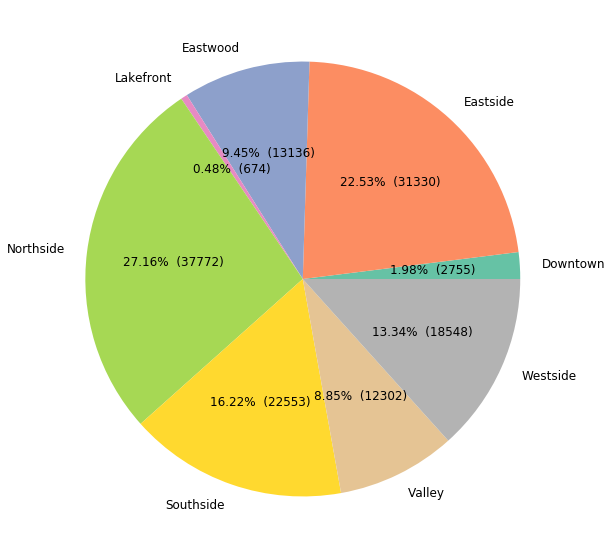

In [19]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

#plt.pie(values, labels=labels, )

plt.figure(figsize=(15,10))

plt.rcParams['font.size']=12
plt.pie(
    # using data total)arrests
    pop['pop1216'],
    # with the labels being officer names
    labels=pop['TNT'],
    # with no shadows
    shadow=False,
    autopct=make_autopct(pop['pop1216']), 
    colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3'], rotatelabels=False
    )
plt.savefig('Group Project/Graph/Pie1.png',bbox_inches = "tight")
plt.show()

## Complaints

In [21]:
comp = df.groupby(['TNT', 'complaint_type_name'])['complaint_type_name'].count().unstack('complaint_type_name').fillna(0).reset_index()
comp['total'] = comp['Blue Bin Skip']+comp['Illegal Trash Set Out']+comp['Trash Skip']
comp['comp%']=(comp['total']/comp['total'].sum())*100
comp.head(10)

complaint_type_name,TNT,Blue Bin Skip,Illegal Trash Set Out,Trash Skip,total,comp%
0,Downtown,0.0,1.0,0.0,1.0,0.014156
1,Eastside,78.0,701.0,329.0,1108.0,15.685164
2,Eastwood,83.0,354.0,164.0,601.0,8.507928
3,Lakefront,0.0,8.0,9.0,17.0,0.240657
4,Northside,178.0,1559.0,629.0,2366.0,33.493771
5,Southside,104.0,886.0,386.0,1376.0,19.479049
6,Valley,57.0,188.0,199.0,444.0,6.285391
7,Westside,67.0,834.0,250.0,1151.0,16.293884


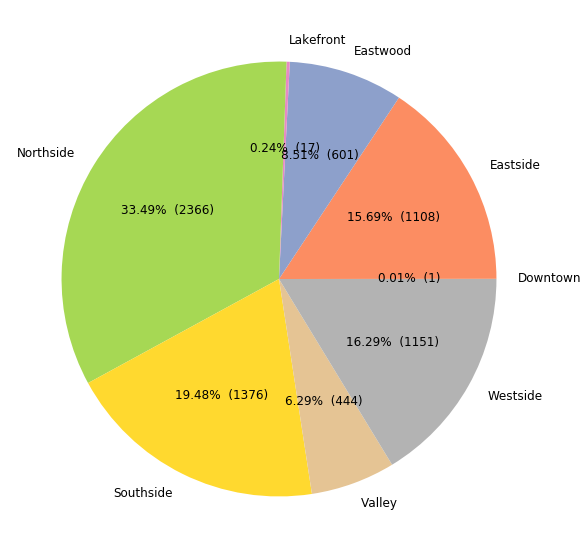

In [26]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

#plt.pie(values, labels=labels, )

plt.figure(figsize=(15,10))
plt.rcParams['font.size']=12
plt.pie(
    # using data total)arrests
    comp['total'],
    # with the labels being officer names
    labels=comp['TNT'],
    # with no shadow
    shadow=False,
    autopct=make_autopct(comp['total']), colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']
    )
plt.savefig('Group Project/Graph/Pie2.png',bbox_inches = "tight")
plt.show()

In [15]:
comp_tnt = pd.merge(comp,
                    pop,
                    on = 'TNT',
                    validate = '1:1',
                    indicator = True)

comp_tnt.head(10)

,TNT,Blue Bin Skip,Illegal Trash Set Out,Trash Skip,total,comp%,pop1216,pop%,_merge
0,Downtown,0.0,1.0,0.0,1.0,0.014156,2755.0,1.981017,both
1,Eastside,78.0,701.0,329.0,1108.0,15.685164,31330.0,22.528223,both
2,Eastwood,83.0,354.0,164.0,601.0,8.507928,13136.0,9.445603,both
3,Lakefront,0.0,8.0,9.0,17.0,0.240657,674.0,0.484648,both
4,Northside,178.0,1559.0,629.0,2366.0,33.493771,37772.0,27.160423,both
5,Southside,104.0,886.0,386.0,1376.0,19.479049,22553.0,16.217013,both
6,Valley,57.0,188.0,199.0,444.0,6.285391,12302.0,8.845905,both
7,Westside,67.0,834.0,250.0,1151.0,16.293884,18548.0,13.337168,both


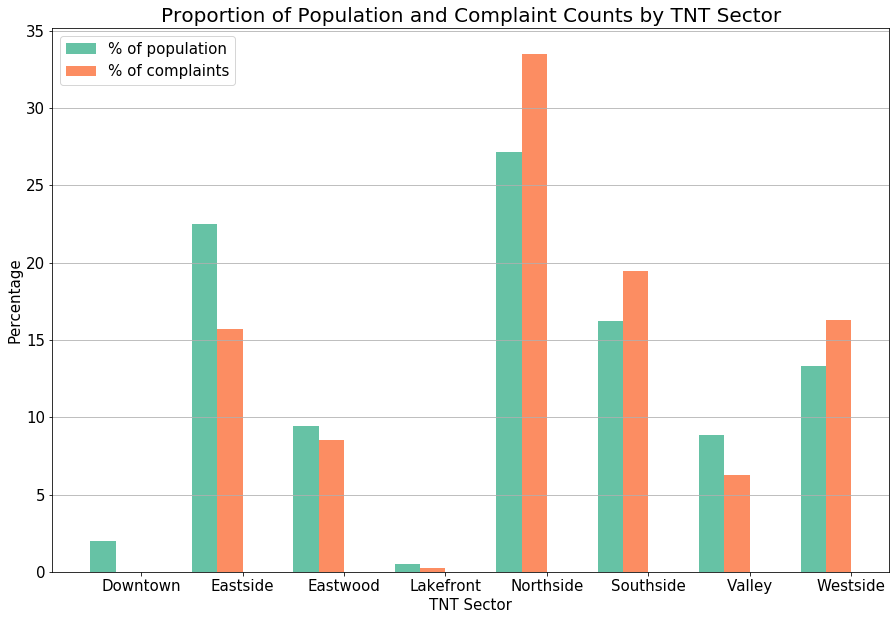

In [16]:
pos = list(range(len(comp_tnt['pop%']))) 
width = 0.25 

fig, ax = plt.subplots(figsize=(15,10))

g1 = plt.bar(pos, 
        #using df['pre_score'] data,
        comp_tnt['pop%'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=1,
        color = '#66c2a5',
        # with label the first value in first_name
        label=comp_tnt['TNT']) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
g1 = plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        comp_tnt['comp%'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=1, color = '#fc8d62' ,
        # with label the first value in first_name
        label=comp_tnt['TNT'][1]) 

ax.set_ylabel('Percentage', fontsize=15)
ax.set_xlabel('TNT Sector', fontsize=15)
# Set the chart's title
ax.set_title('Proportion of Population and Complaint Counts by TNT Sector',fontsize=20)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(comp_tnt['TNT'],fontsize=15)

plt.yticks(fontsize=15)

# Adding the legend and showing the plot
plt.legend(['% of population', 
            '% of complaints'], fontsize=15,loc='upper left')
plt.grid(axis='y')
plt.savefig('Group Project/Graph/Count 1.png',bbox_inches = "tight")

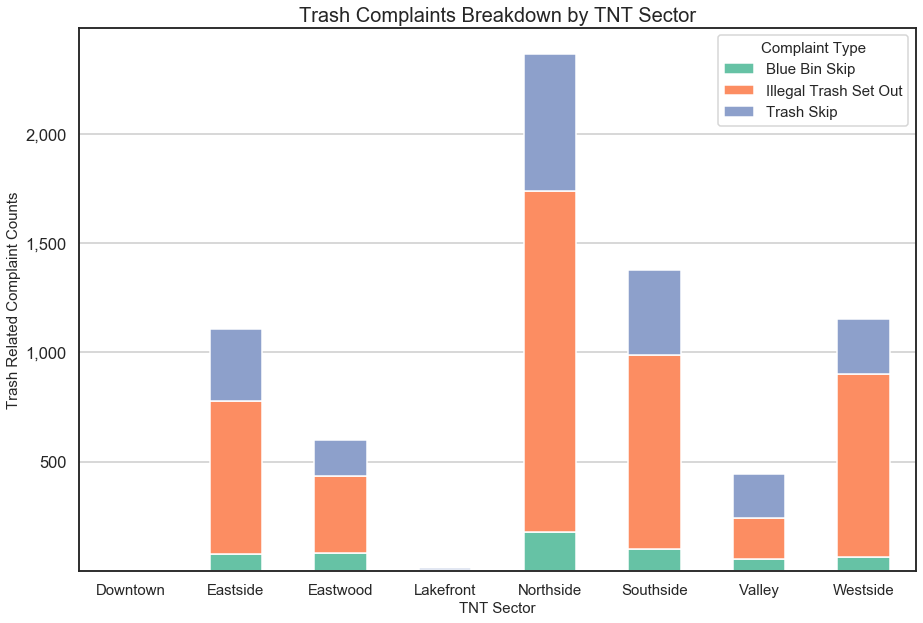

In [17]:
sns.set(font="sans-serif", #The font used for all text
        style="white", #The style of Seaborn
        context="talk", #Preconfigured plot size and scale type in Seaborn; options arranged by size: paper, notebook, talk, and poster
        rc={"figure.figsize":(15, 10), #The size of the figure (y, x) in inches
            "font.size":15, #The default font size
            "axes.titlesize":15, #The size of the x and y axes titles, if titles are set
            "axes.labelsize":10} #The size of the x and y axes labels, if labels are set
        )


nhcomp = df.groupby(['TNT', 'complaint_type_name'])['TNT'].count().unstack('complaint_type_name').fillna(0)
#nhcomp = nhcomp.sort_values('Illegal Trash Set Out', ascending=False)
nhcomp1 = nhcomp.plot(kind = 'bar', 
            stacked = True,  
            title = 'Breakdown of Complaint Types', 
            figsize=(15,10),
            color=['#66c2a5','#fc8d62','#8da0cb']
           )

plt.xticks(rotation=0, fontsize=15)
plt.xlabel('TNT Sector', fontsize=15)
plt.ylabel('Trash Related Complaint Counts', fontsize=15)
plt.title('Trash Complaints Breakdown by TNT Sector', fontsize=20)

plt.yticks([500,1000,1500,2000],['500','1,000','1,500','2,000'])
plt.legend(title='Complaint Type', fontsize=15, title_fontsize=15)
plt.grid(axis='y')
plt.savefig('Group Project/Graph/Count 2.png',bbox_inches = "tight")

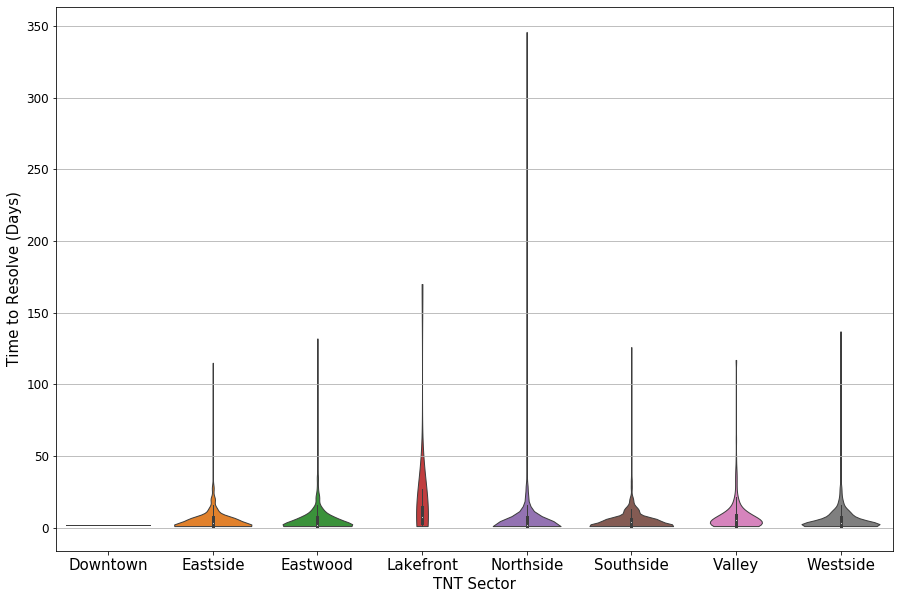

In [46]:
df30 = df[df['close_time'] <= 30 ]
plt.figure(figsize=(15,10))
sns.violinplot(x='TNT', y='close_time', cut=0,
               data=df.sort_values(by='TNT'),linewidth=1)
plt.grid(axis='y')
plt.xticks(rotation=0, fontsize=15)
plt.xlabel('TNT Sector', fontsize=15)
plt.ylabel('Time to Resolve (Days)', fontsize=15)
plt.savefig('Group Project/Graph/TTR2.png',bbox_inches = "tight")

------
# Median Income
## Complaint Count Analysis

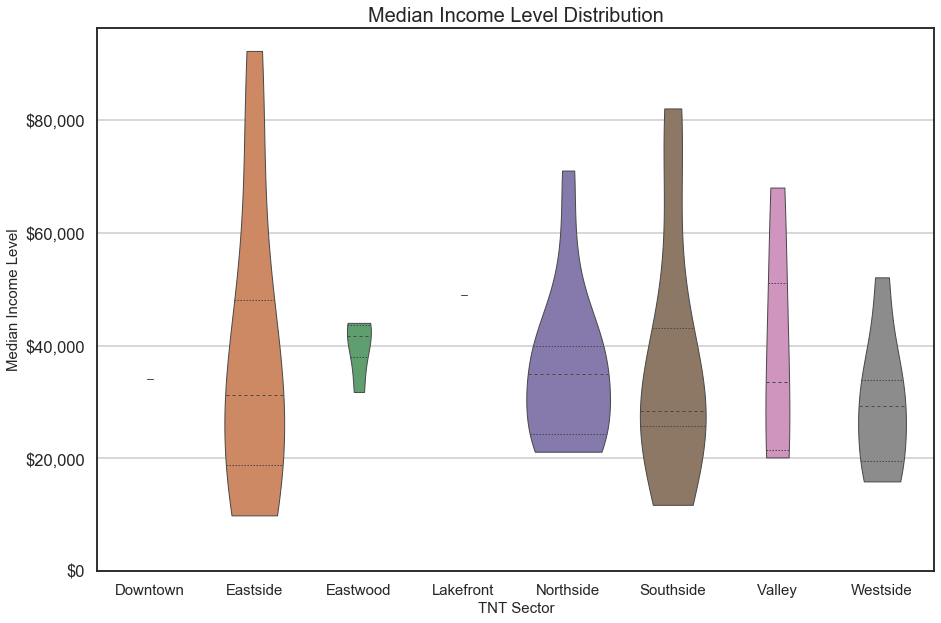

In [19]:
sns.set(font="sans-serif", #The font used for all text
        style="white", #The style of Seaborn
        context="talk", #Preconfigured plot size and scale type in Seaborn; options arranged by size: paper, notebook, talk, and poster
        rc={"figure.figsize":(15, 10), #The size of the figure (y, x) in inches
            "font.size":15, #The default font size
            "axes.titlesize":15, #The size of the x and y axes titles, if titles are set
            "axes.labelsize":10} #The size of the x and y axes labels, if labels are set
        )
dfct = dfct.sort_values('TNT',ascending=True)
sns.violinplot(x='TNT', y="mhinc1216", 
               data=dfct, cut=0,inner='quartile', scale='count',linewidth=1)
plt.grid(axis='y')
plt.xticks(rotation=0, fontsize=15)
plt.xlabel('TNT Sector', fontsize=15)
plt.ylabel('Median Income Level', fontsize=15)
plt.title('Median Income Level Distribution', fontsize=20)
plt.yticks([0, 20000, 40000, 60000, 80000],['$0','$20,000','$40,000','$60,000','$80,000'])
plt.savefig('Group Project/Graph/MHI1.png',bbox_inches = "tight")

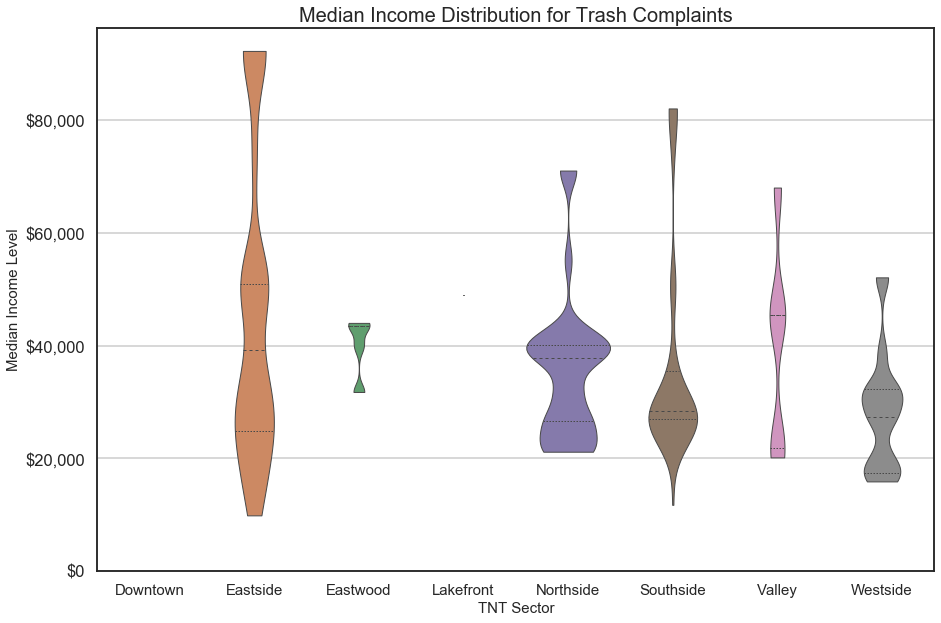

In [20]:
sns.violinplot(x='TNT', y="mhinc1216", 
               data=df.sort_values('TNT'), cut=0,inner='quartile', scale='count',linewidth=1)

plt.grid(axis='y')
plt.xticks(rotation=0, fontsize=15)
plt.xlabel('TNT Sector', fontsize=15)
plt.ylabel('Median Income Level', fontsize=15)
plt.title('Median Income Distribution for Trash Complaints', fontsize=20)
plt.yticks([0, 20000, 40000, 60000, 80000],['$0','$20,000','$40,000','$60,000','$80,000'])
plt.savefig('Group Project/Graph/MHI2.png',bbox_inches = "tight")

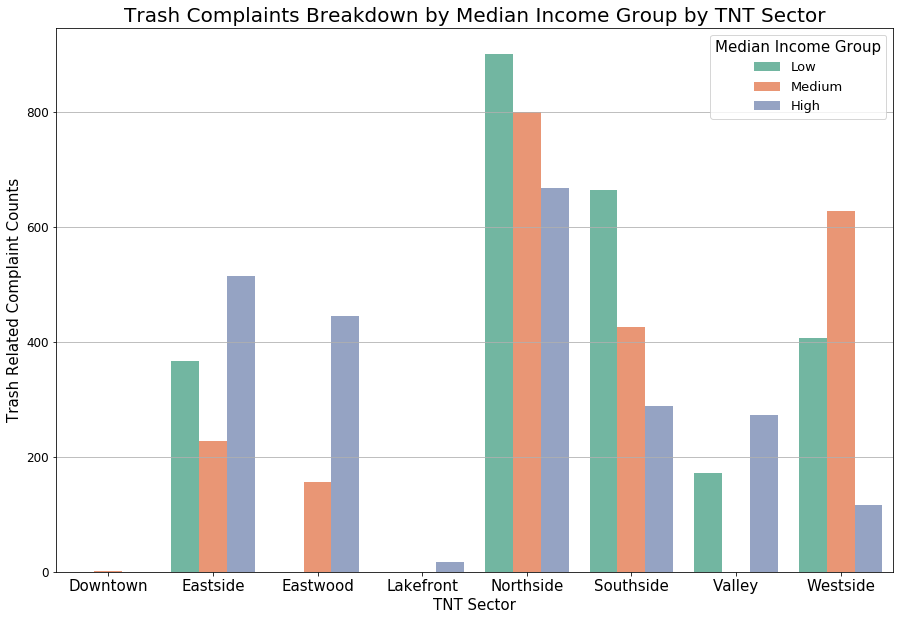

In [40]:
df['mhinccut'] = pd.qcut(df['mhinc1216'], 3, labels=['Low','Medium','High'])
plt.subplots(figsize=(15,10))
sns.countplot(x='TNT',hue='mhinccut',data=df.sort_values('TNT'),palette = ['#66c2a5','#fc8d62','#8da0cb'])
plt.xticks(rotation=0, fontsize=15)
plt.xlabel('TNT Sector', fontsize=15)
plt.ylabel('Trash Related Complaint Counts', fontsize=15)
plt.title('Trash Complaints Breakdown by Median Income Group by TNT Sector', fontsize=20)
plt.legend(title='Median Income Group', fontsize=13, title_fontsize=15)
plt.grid(axis='y')
#plt.savefig('Group Project/Graph/MHI3.png',bbox_inches = "tight")
#['Low:\$9,829.35-\$37,338.83', 'Medium:\$37,338.83-\$64,766.02', 'High:\$64,766.02-\$92,193.22']

In [22]:
ttr = df.groupby(['TNT','FIPS'])['close_time'].mean()
ttr.head()

TNT       FIPS       
Downtown  36067003200    2.000000
Eastside  36067003400    6.785714
          36067003500    4.927928
          36067003601    5.755102
          36067003602    5.074074
Name: close_time, dtype: float64

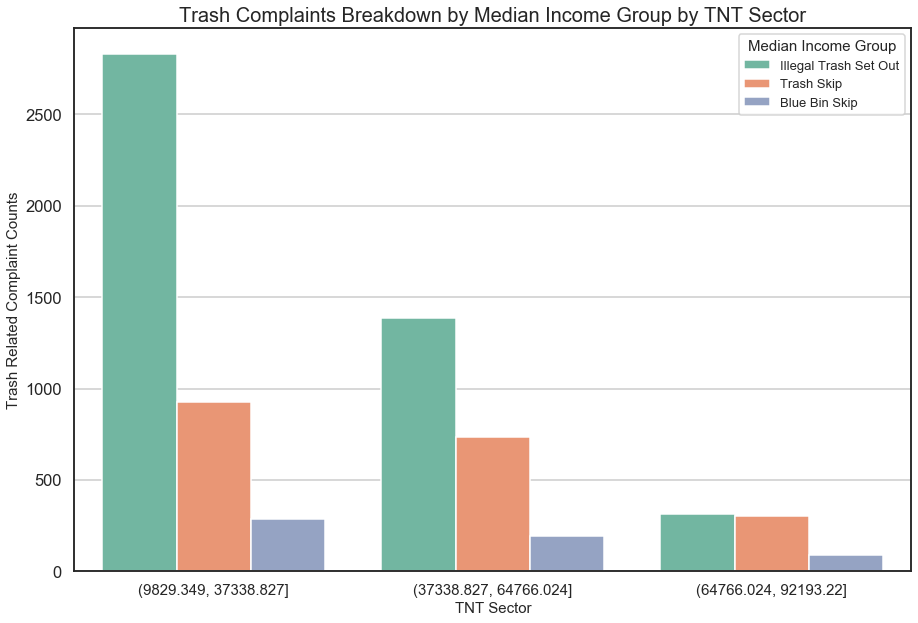

In [23]:
sns.set(font="sans-serif", #The font used for all text
        style="white", #The style of Seaborn
        context="talk", #Preconfigured plot size and scale type in Seaborn; options arranged by size: paper, notebook, talk, and poster
        rc={"figure.figsize":(15, 10), #The size of the figure (y, x) in inches
            "font.size":15, #The default font size
            "axes.titlesize":15, #The size of the x and y axes titles, if titles are set
            "axes.labelsize":10} #The size of the x and y axes labels, if labels are set
        )

df['Median_Income_Range']=pd.cut(df['mhinc1216'],bins=3)

sns.countplot(x='Median_Income_Range', hue="complaint_type_name", data=df,palette = ['#66c2a5','#fc8d62','#8da0cb'])
plt.xticks(rotation=0, fontsize=15)
plt.xlabel('TNT Sector', fontsize=15)
plt.ylabel('Trash Related Complaint Counts', fontsize=15)
plt.title('Trash Complaints Breakdown by Median Income Group by TNT Sector', fontsize=20)
plt.legend(title='Median Income Group', fontsize=13, title_fontsize=15)
plt.grid(axis='y')

In [24]:
df['Median_Income_Range'].unique()

[(37338.827, 64766.024], (9829.349, 37338.827], (64766.024, 92193.22], NaN]
Categories (3, interval[float64]): [(9829.349, 37338.827] < (37338.827, 64766.024] < (64766.024, 92193.22]]

## Time to Close

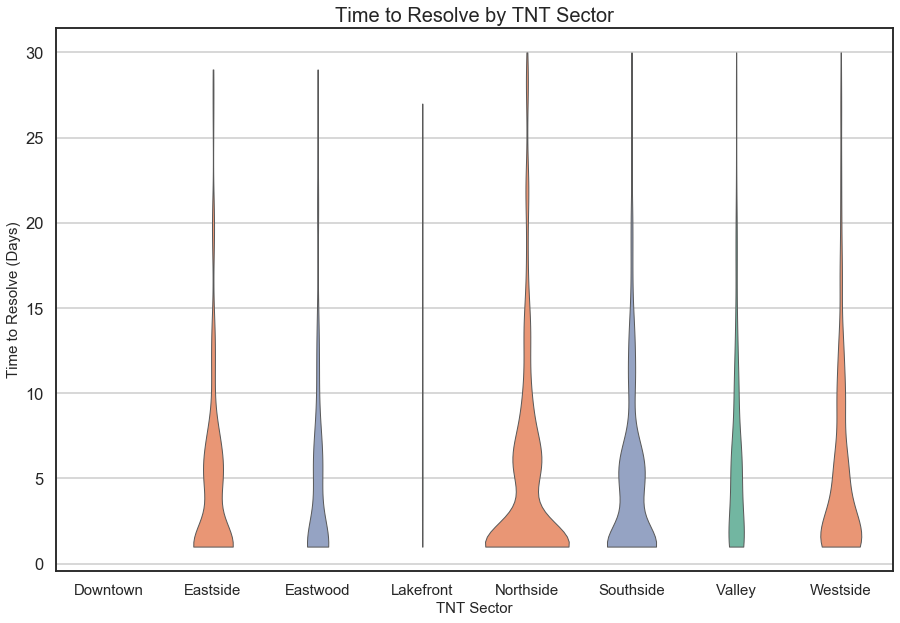

In [30]:
df30 = df30.sort_values(by='TNT')
sns.violinplot(x="TNT", y="close_time", data=df30, palette=['#66c2a5','#fc8d62','#8da0cb'],scale='count',cut=0,inner=None, linewidth=1)


plt.grid(axis='y')
plt.xticks(rotation=0, fontsize=15)
plt.xlabel('TNT Sector', fontsize=15)
plt.ylabel('Time to Resolve (Days)', fontsize=15)
plt.title('Time to Resolve by TNT Sector', fontsize=20)
plt.savefig('Group Project/Graph/TTR1.png',bbox_inches = "tight")

------
# Education
##

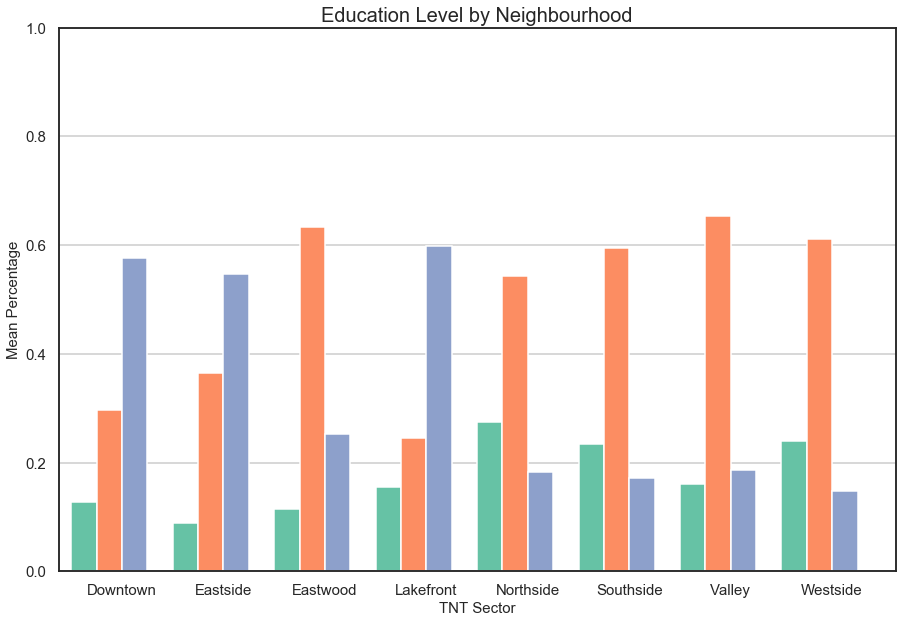

In [170]:
fip_df_subset = df[["TNT",'pedlt1216','pedhs1216','pedba1216']].dropna()
fip_df_subset = fip_df_subset.groupby(["TNT"])['pedlt1216','pedhs1216','pedba1216'].agg([np.mean]).reset_index()
fip_df_subset.columns = ['TNT', 'pedlt1216', 'pedhs1216', 'pedba1216']

# Setting the positions and width for the bars
pos = list(range(len(fip_df_subset['pedlt1216']))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(15,10))

# Create a bar with pre_score data,
# in position pos,
H4 = plt.bar(pos, 
        #using df['pre_score'] data,
        fip_df_subset['pedlt1216'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color
        color='#66c2a5', 
        # with label the first value in first_name
        label=fip_df_subset['TNT'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
H4 = plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        fip_df_subset['pedhs1216'],
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color
        color='#fc8d62', 
        # with label the second value in first_name
        label=fip_df_subset['TNT'][1]) 

# Create a bar with post_score data,
# in position pos + some width buffer,
H4 = plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        fip_df_subset['pedba1216'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color
        color='#8da0cb', 
        # with label the third value in first_name
        label=fip_df_subset['TNT'][2]) 

# Set the y axis label
ax.set_ylabel('Mean Percentage', fontsize=15)
ax.set_xlabel('TNT Sector', fontsize=15)
# Set the chart's title
ax.set_title('Education Level by Neighbourhood',fontsize=20)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(fip_df_subset['TNT'],fontsize=15)

plt.yticks(fontsize=15)


# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(fip_df_subset['pedlt1216'] + fip_df_subset['pedhs1216'] + fip_df_subset['pedba1216'])] )

# Adding the legend and showing the plot
plt.legend(['% Without High School degree of population aged 25+', 
            '% high school graduate without college degree of population aged 25+',
            '% college gradutes population aged 25+'], fontsize=15,loc='upper left')
plt.grid(axis='y')

plt.show()

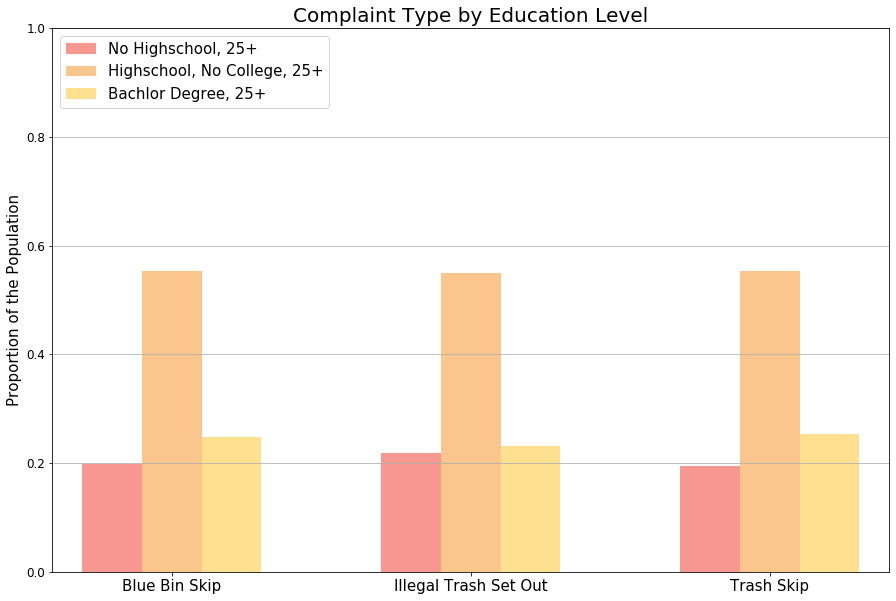

In [38]:
data_trash_complaints = df[["complaint_type_name",'pedlt1216','pedhs1216','pedba1216']].dropna()
fip_df_subset = data_trash_complaints.groupby(["complaint_type_name"])['pedlt1216','pedhs1216','pedba1216'].agg([np.mean]).reset_index()
fip_df_subset.columns = ['complaint_type_name', 'pedlt1216', 'pedhs1216', 'pedba1216']

# Setting the positions and width for the bars
pos = list(range(len(fip_df_subset['pedlt1216']))) 
width = 0.2 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(15,10))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        fip_df_subset['pedlt1216'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3220', 
        # with label the first value in first_name
        label=fip_df_subset['complaint_type_name'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        fip_df_subset['pedhs1216'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F78F1E', 
        # with label the second value in first_name
        label=fip_df_subset['complaint_type_name'][0]) 

# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        fip_df_subset['pedba1216'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FFC222', 
        # with label the third value in first_name
        label=fip_df_subset['complaint_type_name'][0]) 

# Set the y axis label
ax.set_ylabel('Proportion of the Population',fontsize=15)

# Set the chart's title
ax.set_title('Complaint Type by Education Level', fontsize=20)

# Set the position of the x ticks
ax.set_xticks([p + 1 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(fip_df_subset['complaint_type_name'],fontsize=15)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*3)
plt.ylim([0, max(fip_df_subset['pedlt1216'] + fip_df_subset['pedhs1216'] + fip_df_subset['pedba1216'])] )

# Adding the legend and showing the plot
plt.legend(['No Highschool, 25+', 'Highschool, No College, 25+', 'Bachlor Degree, 25+'], loc='upper left', fontsize=15)
plt.grid(axis='y')
plt.savefig('Group Project/Graph/Edu1.png',bbox_inches = "tight")
plt.show()

---
# % Foreign Born

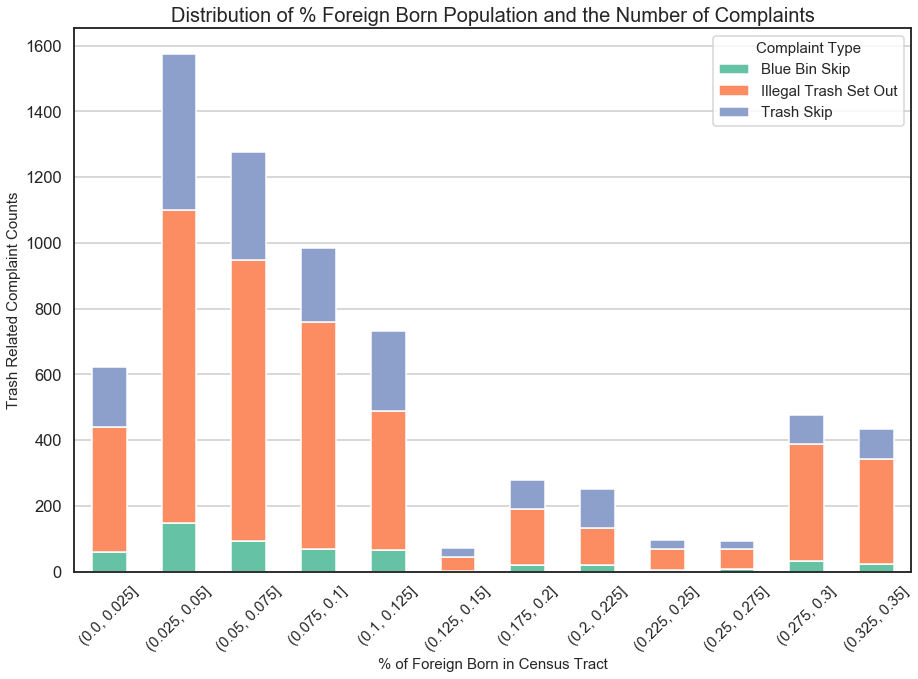

In [24]:
sns.set(font="sans-serif", #The font used for all text
        style="white", #The style of Seaborn
        context="talk", #Preconfigured plot size and scale type in Seaborn; options arranged by size: paper, notebook, talk, and poster
        rc={"figure.figsize":(15, 10), #The size of the figure (y, x) in inches
            "font.size":15, #The default font size
            "axes.titlesize":15, #The size of the x and y axes titles, if titles are set
            "axes.labelsize":10} #The size of the x and y axes labels, if labels are set
        )

df['PercentForeign_Range']=pd.cut(df['pfb1216'],bins=np.linspace(0.0, 0.40, num = 16, endpoint=False))
df['PercentForeign_Range'].value_counts()
f2 = df.groupby(['PercentForeign_Range', 'complaint_type_name'])['PercentForeign_Range'].count().unstack('complaint_type_name').fillna(0)
f2 = f2.plot(kind = 'bar', 
            stacked = True,  
            title = 'Number of complaint at different Foreign born, break down by complaint type', 
            figsize = (15,10), color=['#66c2a5','#fc8d62','#8da0cb'])


plt.xticks(rotation=45, fontsize=15)
plt.xlabel('% of Foreign Born in Census Tract', fontsize=15)
plt.ylabel('Trash Related Complaint Counts', fontsize=15)
plt.title('Distribution of % Foreign Born Population and the Number of Complaints', fontsize=20)

plt.legend(title='Complaint Type', fontsize=15, title_fontsize=15)
plt.grid(axis='y')

-----
# Complaint Rate

In [25]:
comp_tnt['comp_rate'] = (comp_tnt['total']/comp_tnt['pop1216']) * 100
comp_tnt.head(10)
atc = df.groupby('TNT', as_index=False)['close_time'].mean().copy()
comp_tnt=comp_tnt.merge(atc, on = 'TNT')
mhinc = df.groupby('TNT', as_index=False)['mhinc1216'].mean().copy()
comp_tnt=comp_tnt.merge(mhinc, on = 'TNT')
comp_tnt

,TNT,Blue Bin Skip,Illegal Trash Set Out,Trash Skip,total,comp%,pop1216,pop%,_merge,comp_rate,close_time,mhinc1216
0,Downtown,0.0,1.0,0.0,1.0,0.014156,2755.0,1.981017,both,0.036298,2.000000,34005.260000
1,Eastside,78.0,701.0,329.0,1108.0,15.685164,31330.0,22.528223,both,3.536546,5.406137,46115.329930
2,Eastwood,83.0,354.0,164.0,601.0,8.507928,13136.0,9.445603,both,4.575213,5.642263,39748.508419
3,Lakefront,0.0,8.0,9.0,17.0,0.240657,674.0,0.484648,both,2.522255,18.764706,48864.000000
4,Northside,178.0,1559.0,629.0,2366.0,33.493771,37772.0,27.160423,both,6.263899,5.970837,35745.226986
5,Southside,104.0,886.0,386.0,1376.0,19.479049,22553.0,16.217013,both,6.101184,5.354651,36370.060167
6,Valley,57.0,188.0,199.0,444.0,6.285391,12302.0,8.845905,both,3.609169,7.817568,40573.619279
7,Westside,67.0,834.0,250.0,1151.0,16.293884,18548.0,13.337168,both,6.205521,5.928758,28535.978671


In [177]:
comp_tnt.to_csv('Group Project/Complaint Rate.csv')

In [26]:
data = df.groupby(['TNT', 'FIPS','complaint_type_name'])['complaint_type_name'].count().unstack('complaint_type_name').fillna(0).reset_index()
data['total'] = data['Blue Bin Skip']+data['Illegal Trash Set Out']+data['Trash Skip']
data['comp%']=(data['total']/data['total'].sum())*100
data.head(10)

dfd = dfd[['FIPS','pop1216','mhinc1216', 'pfb1216', 'pedlt1216', 'pedhs1216', 'pedba1216']]
data = data.merge(dfd, on='FIPS',how='left')
data['pop%'] = (data['pop1216'] / data['pop1216'].sum()) * 100


atc = df.groupby('FIPS', as_index=False)['close_time'].mean().copy()

data = data.merge(atc, on = 'FIPS')


In [176]:
corr = data[['comp%','pop%','mhinc1216', 'pfb1216', 'pedlt1216', 'pedhs1216', 'pedba1216','total','close_time']].corr()
corr.to_csv('Group Project/Correlation.csv')

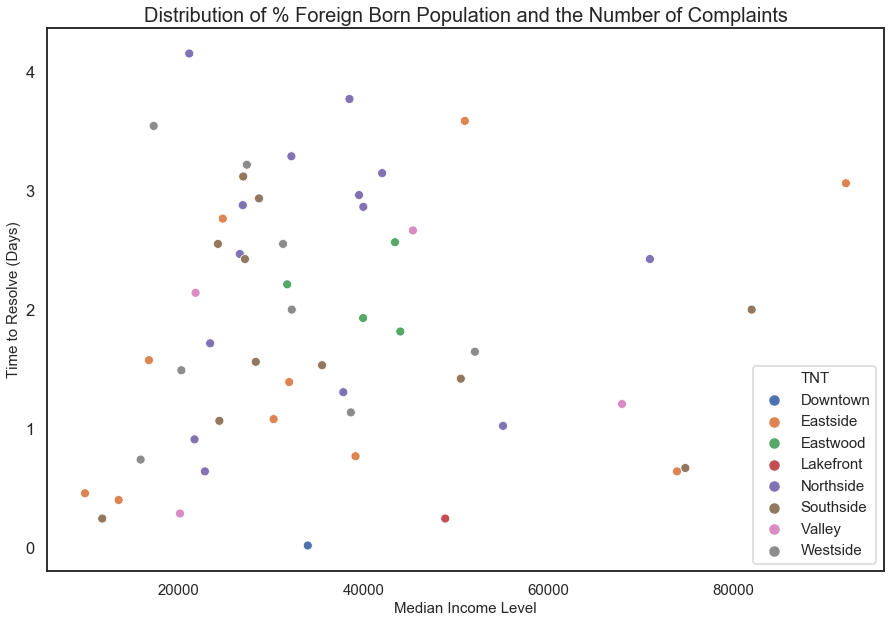

In [71]:
sns.scatterplot(x="mhinc1216", y="comp%",
                     hue="TNT",  data=data)

plt.xticks(rotation=0, fontsize=15)
plt.xlabel('Median Income Level', fontsize=15)
plt.ylabel('Average Time to Resolve (Days)', fontsize=15)
plt.title('Distribution of % Foreign Born Population and the Number of Complaints', fontsize=20)
plt.legend(fontsize=15, title_fontsize=15)


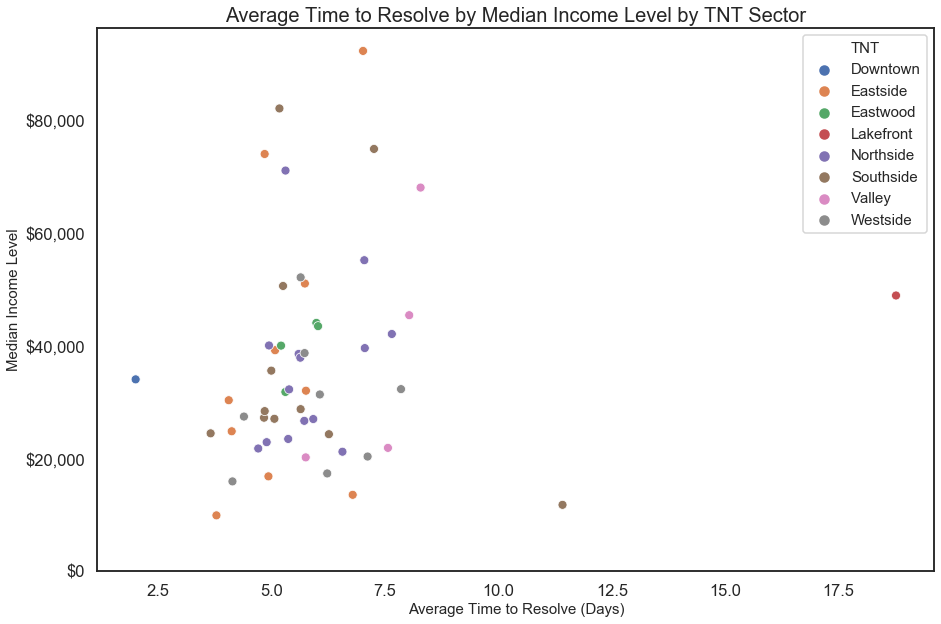

In [175]:
sns.scatterplot(x="close_time", y="mhinc1216",
                     hue="TNT",  data=data)

plt.yticks([0, 20000, 40000, 60000, 80000],['$0','$20,000','$40,000','$60,000','$80,000'])
plt.xlabel('Average Time to Resolve (Days)', fontsize=15)
plt.ylabel('Median Income Level', fontsize=15)
plt.title('Average Time to Resolve by Median Income Level by TNT Sector', fontsize=20)
plt.legend(fontsize=15, title_fontsize=15)
plt.savefig('Group Project/Graph/MHI9.png',bbox_inches = "tight")

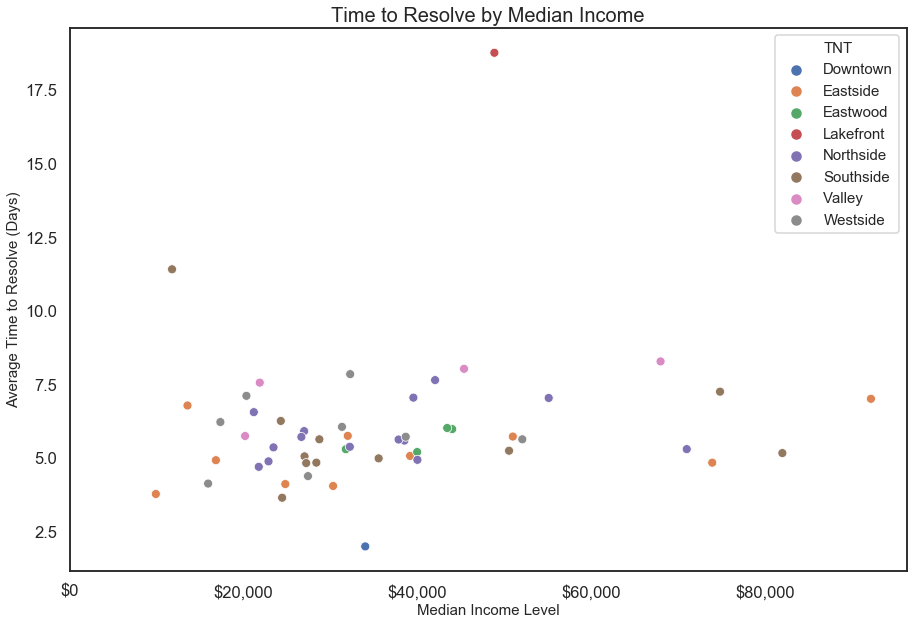

In [128]:
sns.scatterplot(x="mhinc1216", y="close_time",
                     hue="TNT",  data=data)

#plt.xticks(rotation=0, fontsize=15)
plt.xlabel('Median Income Level', fontsize=15)
plt.ylabel('Average Time to Resolve (Days)', fontsize=15)
plt.title('Time to Resolve by Median Income', fontsize=20)
plt.xticks([0, 20000, 40000, 60000, 80000],['$0','$20,000','$40,000','$60,000','$80,000'])
plt.legend(fontsize=15, title_fontsize=15)
plt.savefig('Group Project/Graph/MHI5.png',bbox_inches = "tight")

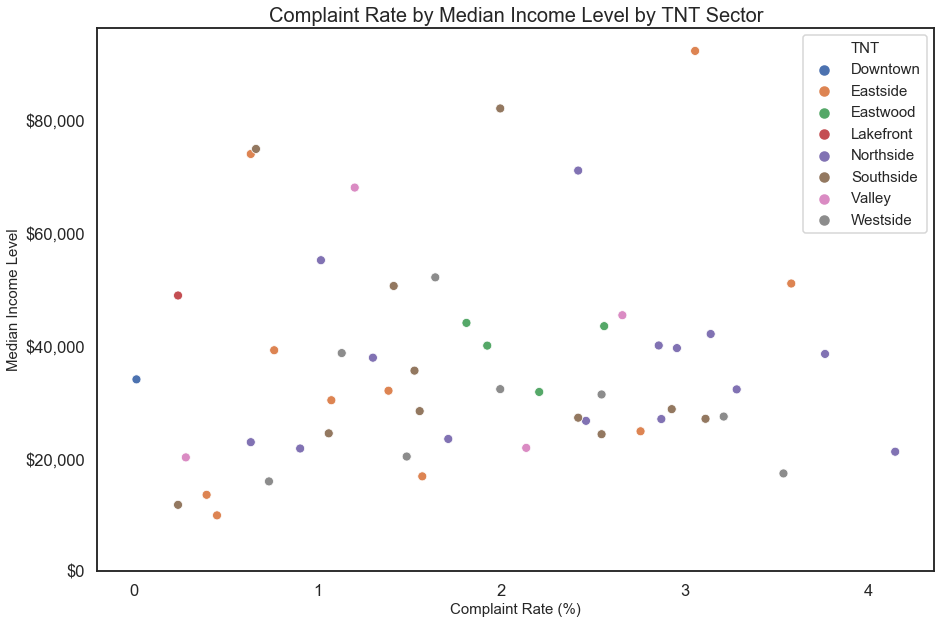

In [157]:
sns.scatterplot(x="comp%", y="mhinc1216",
                     hue="TNT",  data=data)

#plt.xticks(rotation=0, fontsize=15)
plt.xlabel('Complaint Rate (%)', fontsize=15)
plt.ylabel('Median Income Level', fontsize=15)
plt.title('Complaint Rate by Median Income Level by TNT Sector', fontsize=20)
plt.yticks([0, 20000, 40000, 60000, 80000],['$0','$20,000','$40,000','$60,000','$80,000'])
plt.legend(fontsize=15, title_fontsize=15)
#plt.savefig('Group Project/Graph/MHI6.png',bbox_inches = "tight")

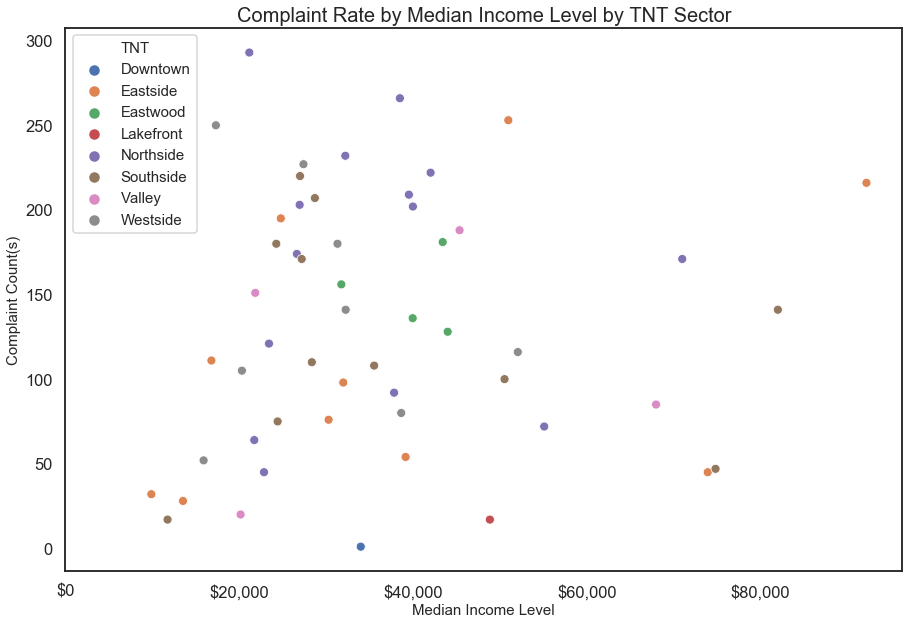

In [144]:
sns.scatterplot(x="mhinc1216", y="total",
                     hue="TNT",  data=data)

#plt.xticks(rotation=0, fontsize=15)
plt.xlabel('Median Income Level', fontsize=15)
plt.ylabel('Complaint Count(s)', fontsize=15)
plt.title('Complaint Rate by Median Income Level by TNT Sector', fontsize=20)
plt.xticks([0, 20000, 40000, 60000, 80000],['$0','$20,000','$40,000','$60,000','$80,000'])
plt.legend(fontsize=15, title_fontsize=15)
plt.savefig('Group Project/Graph/MHI7.png',bbox_inches = "tight")

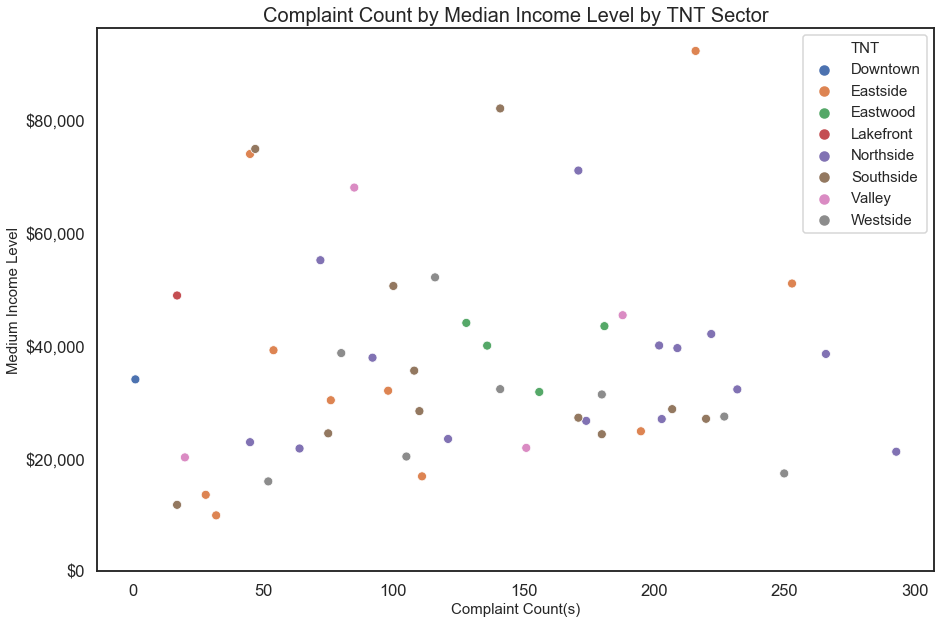

In [155]:
sns.scatterplot(x="total",y="mhinc1216", 
                     hue="TNT",  data=data)

#plt.xticks(rotation=0, fontsize=15)
plt.xlabel('Complaint Count(s)', fontsize=15)
plt.ylabel('Medium Income Level', fontsize=15)
plt.title('Complaint Count by Median Income Level by TNT Sector', fontsize=20)
plt.yticks([0, 20000, 40000, 60000, 80000],['$0','$20,000','$40,000','$60,000','$80,000'])
plt.legend(fontsize=15, title_fontsize=15)
plt.savefig('Group Project/Graph/MHI8.png',bbox_inches = "tight")

No handles with labels found to put in legend.


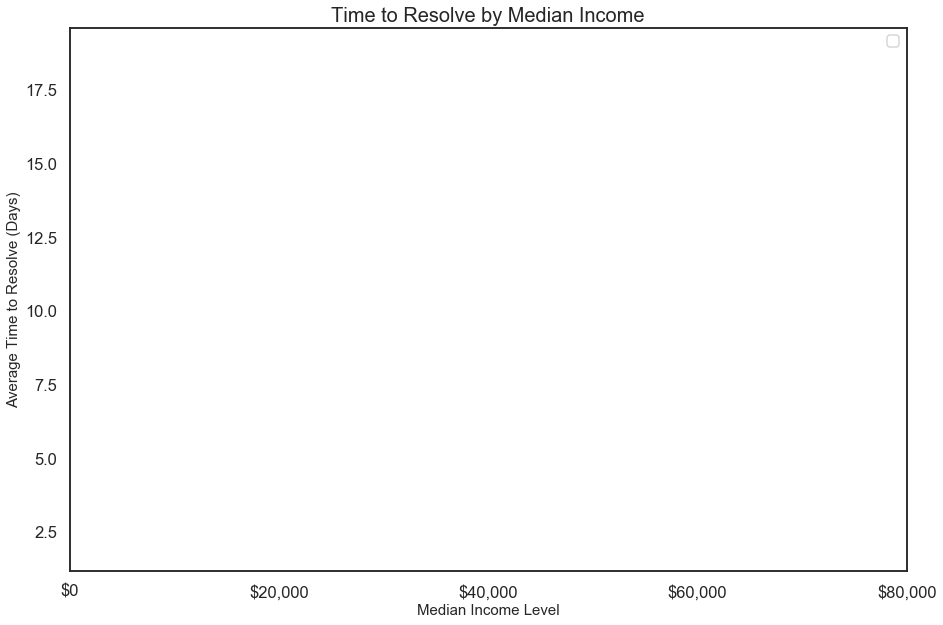

In [130]:
sns.violinplot(x="mhinc1216", y="close_time",data=data)

#plt.xticks(rotation=0, fontsize=15)
plt.xlabel('Median Income Level', fontsize=15)
plt.ylabel('Average Time to Resolve (Days)', fontsize=15)
plt.title('Time to Resolve by Median Income', fontsize=20)
plt.xticks([0, 20000, 40000, 60000, 80000],['$0','$20,000','$40,000','$60,000','$80,000'])
plt.legend(fontsize=15, title_fontsize=15)
#plt.savefig('Group Project/Graph/MHI5.png',bbox_inches = "tight")

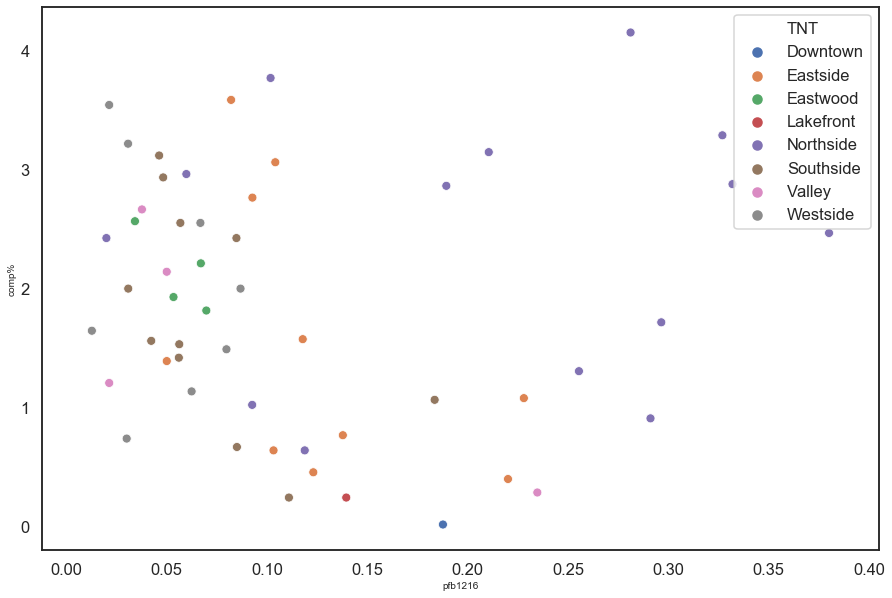

In [30]:
sns.scatterplot(x="pfb1216", y="comp%",
                     hue="TNT",  data=data)

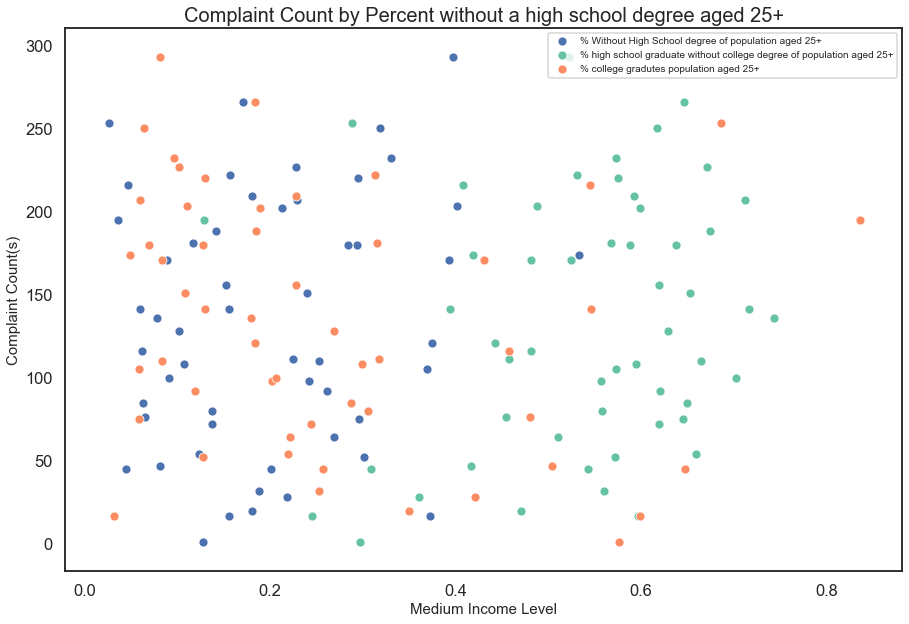

In [174]:
g2 = sns.scatterplot(x="pedlt1216", y="total", data=data)
g2 = sns.scatterplot(x='pedhs1216', y='total', data=data, color='#66c2a5')
g2 = sns.scatterplot(x='pedba1216', y='total', data=data, color='#fc8d62')

plt.ylabel('Complaint Count(s)', fontsize=15)
plt.xlabel('Population (%)', fontsize=15)
plt.title('Complaint Count by Education Level', fontsize=20)
plt.legend(['% Without High School degree of population aged 25+', 
            '% high school graduate without college degree of population aged 25+',
            '% college gradutes population aged 25+'], fontsize=10)
#plt.savefig('Group Project/Graph/MHI8.png',bbox_inches = "tight")

-----
# Grouped Complaint Rate

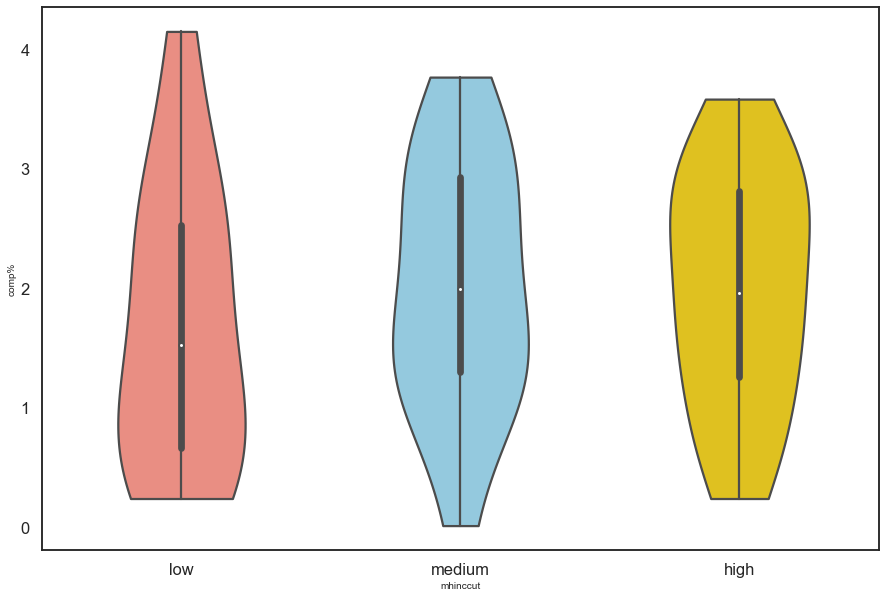

In [32]:
data['mhinccut'] = pd.qcut(data['mhinc1216'], 3, labels=['low', 'medium', 'high'])

sns.violinplot(data=data,
                    x='mhinccut', 
                    y='comp%', 
                    width=0.5,
                    palette=['salmon','skyblue','gold'], cut=0)

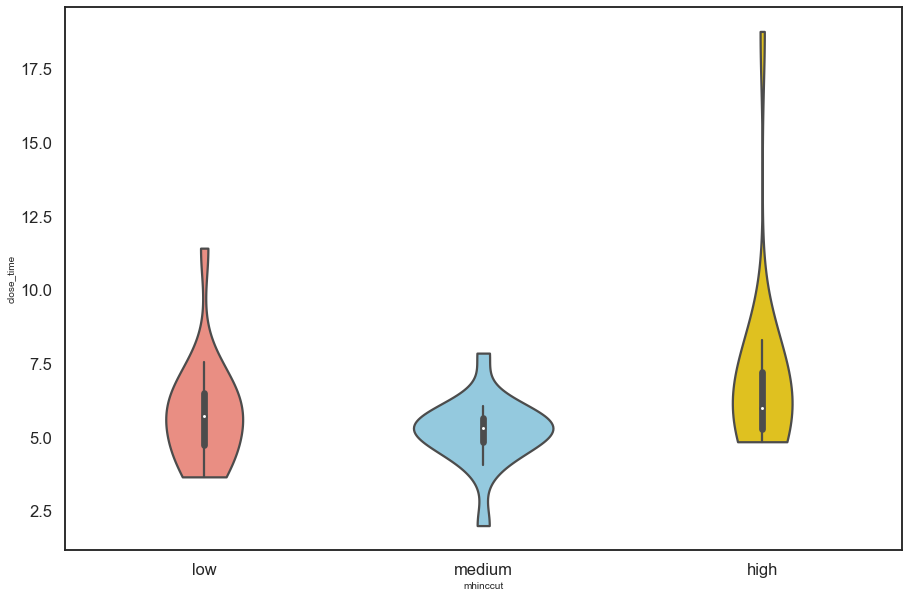

In [33]:
sns.violinplot(data=data,
                    x='mhinccut', 
                    y='close_time', 
                    width=0.5,
                    palette=['salmon','skyblue','gold'], cut=0)

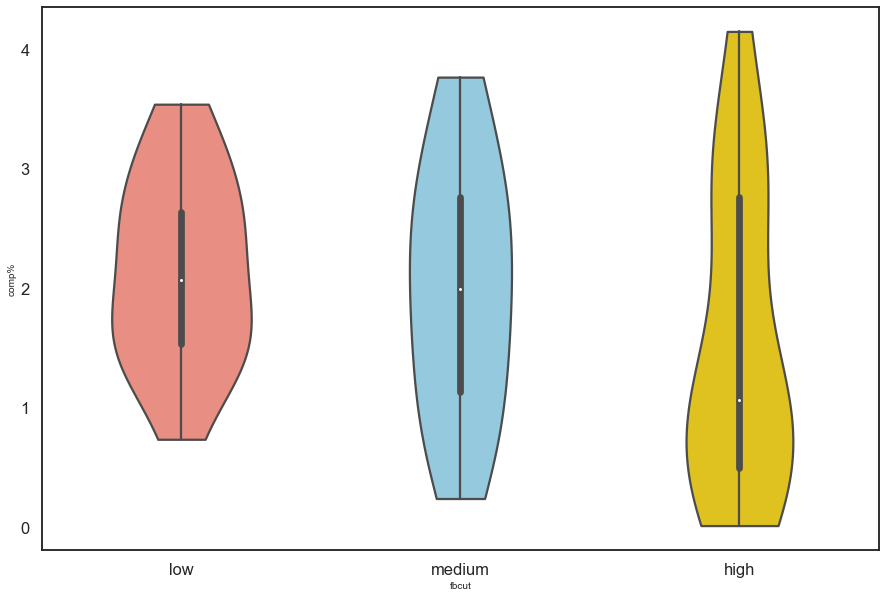

In [34]:
data['fbcut'] = pd.qcut(data['pfb1216'], 3, labels=['low', 'medium', 'high'])

sns.violinplot(data=data,
                    x='fbcut', 
                    y='comp%', 
                    width=0.5,
                    palette=['salmon','skyblue','gold'], cut=0)

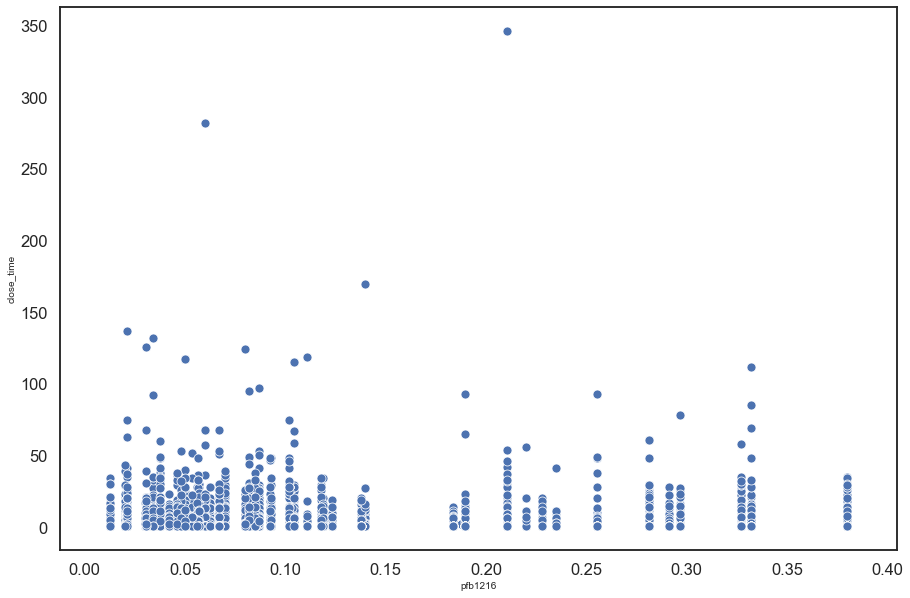

In [46]:
sns.scatterplot(data=df,
                    x='pfb1216', 
                    y='close_time')

-----
# GIS
## 1. Overlap of Census Tract & TNT Sector

In [35]:
ct = gpd.read_file(r'Data/original/Census_Tracts_in_Syracuse_NY_2010.shp')
ct.rename(columns={'GEOID10':'FIPS'}, inplace = True)

tnt = gpd.read_file(r'Data/original/Syracuse_TNT_Areas.shp')

In [48]:
map = folium.Map(location=[43.0500445,-76.14911819999999],
                  tiles='cartodbpositron', #specific style/type for map
                  zoom_start=12,
                  control_scale=True,
                  layer_control=True
                )


tntj=tnt.to_json()

folium.GeoJson(tntj,
               style_function = lambda x: {'fillColor': '#00000000','color': 'orange','weight' : 2, 'fillOpacity' : 0.5},
               highlight_function=lambda x: {'weight':3, 'color':'black','fillOpacity':1},
               show=True,
               overlay=True,
               control=True,
               tooltip = folium.features.GeoJsonTooltip(fields=['TNT_NAME'], aliases=['TNT_NAME'],style="color:black;font-size=42pt",labels=True)).add_to(map)
folium.GeoJson(ct.to_json(),style_function=lambda x: {'fillColor': '#00000000','color': 'blue','weight' : 1, 'fillOpacity' : 0.5},
              tooltip = folium.features.GeoJsonTooltip(fields=['NAME10'], aliases=['NAME10'],style="color:black;font-size=42pt",labels=True)).add_to(map)

map
map.save('data/output/GP3.html')    

In [37]:
def getXY(pt):
    return (pt.x, pt.y)
tnt2 = tnt
tnt2['lat'] = tnt2['geometry'].centroid.x
tnt2['lon'] = tnt2['geometry'].centroid.y
tnt2[['lat','lon']].head(10)

from folium.features import DivIcon

for i,row in tnt2.iterrows(): 
    # This command creates a circle-shaped marker on the map at a point based on the lat & lon values stored in each row of tv_add
    folium.Marker(location=[row['lon'],row['lat']], 
                        icon=DivIcon(icon_size=(40,40),icon_anchor=(15,10),html=row['TNT_NAME'])
                       ).add_to(map)
map
map.save('data/output/GP2.html')     

## 2. Complaint Frequency by TNT

In [38]:
dfgeo = pd.read_csv(r'Data/working/cityline_acs_geocoded.csv', dtype={'FIPS': 'str'})
dfgeo = GeoDataFrame(dfgeo, crs={'init': 'epsg:4326'})

In [39]:
dfgeo_bb = dfgeo[dfgeo['complaint_type_name']=='Blue Bin Skip'].copy()
dfgeo_bb.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 765 entries, 85 to 56394
Data columns (total 220 columns):
ObjectId                         int64
close_date                       object
complaint_number                 object
complaint_type_name              object
department_name                  object
identifier                       object
number                           object
open_date                        object
place                            object
point                            object
received_via_type_name           object
status_type_name                 object
street_address                   object
user_defined_action_type_name    object
zip                              int64
latitude                         float64
longitude                        float64
geometry                         object
FIPS                             object
NAME                             object
areal1216                        float64
pop1216                          float64
a

In [40]:
m = folium.Map(location=[43.0500445,-76.14911819999999],
               tiles='cartodbpositron',
               zoom_start=13,
               zoom_control = True,
               control_scale = True)

folium.GeoJson(tntj,
               style_function = lambda x: {'fillColor': '#00000000','color': 'orange','weight' : 2, 'fillOpacity' : 0.5},
               highlight_function=lambda x: {'weight':3, 'color':'black','fillOpacity':1},
               show=True,
               overlay=True,
               control=True).add_to(m)
m

In [41]:
for i,row in dfgeo_bb.iterrows():
    # This command creates a circle-shaped marker on the map at a point based on the lat & lon values stored in each row of {your_dataframe_name_here}
    folium.CircleMarker((row['latitude'],row['longitude']), 
                        radius=2, 
                        weight=2, 
                        color='blue', 
                        fill_color='blue', 
                        fill_opacity=.4
                       ).add_to(m)
m

In [42]:
dfgeo_trash = dfgeo[dfgeo['complaint_type_name']=='Trash Skip'].copy()
dfgeo_trash.shape

(2447, 220)

In [43]:
for i,row in dfgeo_trash.iterrows():
    # This command creates a circle-shaped marker on the map at a point based on the lat & lon values stored in each row of {your_dataframe_name_here}
    folium.CircleMarker((row['latitude'],row['longitude']), 
                        radius=2, 
                        weight=2, 
                        color='red', 
                        fill_color='red', 
                        fill_opacity=.4
                       ).add_to(m)
m
m.save('data/working/GP.html')